In [1]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================

In [2]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=3)

# Define Hamiltonian for quantum computations
# H = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

# H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2)])
# H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)])

H = qml.Hamiltonian(
    coeffs=[-0.5, -1], 
    observables=[
        qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2), 
        qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)
    ]
)

H_1 = qml.Hamiltonian(
    coeffs=[-0.5, -0.5, -0.5], 
    observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)]
)

In [3]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(6)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """
    Calculates the dephasing factor as a function of the time parameter tau.

    Args:
        tau (float): A time parameter influencing the dephasing.

    Returns:
        float: The calculated dephasing factor.
    """
    return 1 - pnp.exp(-2 * tau)

In [4]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z1 = Paras_global[1]
    phi_z2 = Paras_global[2]
    phi_z3 = Paras_global[3]
    tau_1 = Paras_global[4]
    tau_2 = Paras_global[5]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    qml.RY(np.pi/2, wires=2)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    qml.PhaseDamping(gamma_dephase, wires = 2)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    
    qml.RX(theta_x, wires = 2)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   
    qml.RY(-np.pi/2, wires = 2)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    
    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    qml.RY(np.pi/2, wires = 2) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 

    qml.RZ(phi_z1, wires=0)
    qml.RZ(phi_z2, wires=1)
    qml.RZ(phi_z3, wires=2)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    qml.RX(np.pi/(2), wires=2)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1, 2])

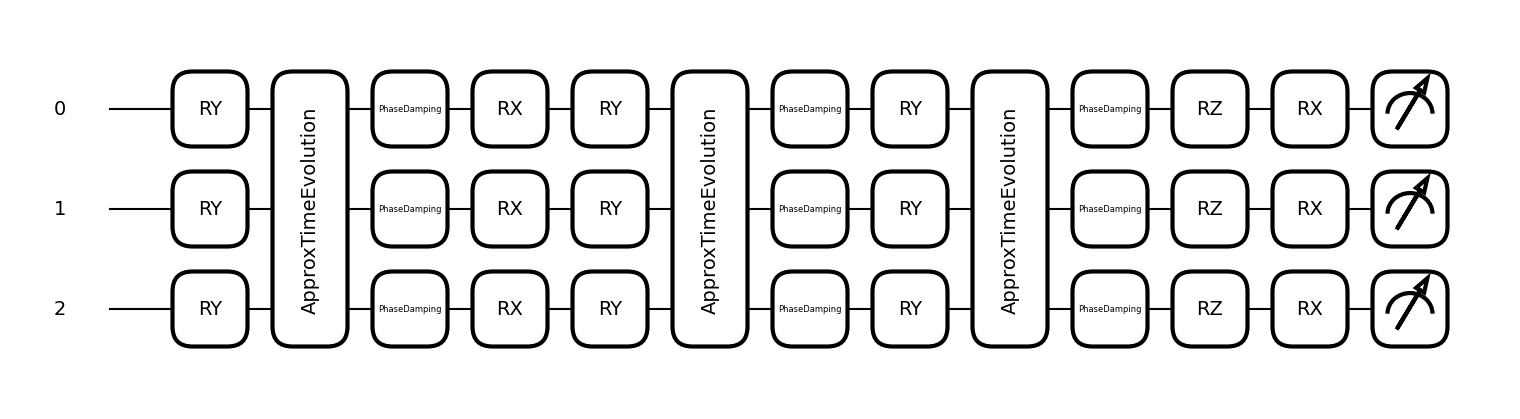

In [5]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [6]:
@qml.qnode(dev)
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.tensor([
        [pnp.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=pnp.complex128)
    
    Numerator = pnp.kron(K, pnp.kron(K, K)) @ get_density_matrix @ pnp.kron(K, pnp.kron(K, K)).conj().T
    Denominator = pnp.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1, 2])
    
    return qml.density_matrix(wires = [0, 1, 2])  

In [7]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Sets global parameters for dephasing time and gamma post-selection.

    Args:
        desired_tau_dephase (float): The desired dephasing time.
        desired_gamma_post_selection (float): The gamma value for post-selection.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [8]:
def cost_function(paras):
    """
    Defines the cost function for optimization, which is the negative of the 
    Classical Fisher Information (CFI).

    Args:
        paras (array): Parameters to optimize.

    Returns:
        float: The negative value of the CFI for the given parameters.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [9]:
class INDEX_3(Enum):
    THETA_X = 0
    
    PHI_Z1 = 1
    PHI_Z2 = 2
    PHI_Z3 = 3
    
    TAU_1 = 4
    TAU_2 = 5
    
def get_constraints(phi_current):
    N =2*np.pi * int(phi_current / (2*np.pi))
    default_0 = [
                (-float('inf'), float('inf')),              # THETA_X
                (-float('inf'), float('inf')),       # PHI_Z1
                (-float('inf'), float('inf')),  # PHI_Z2
                (-float('inf'), float('inf')),       # PHI_Z3
                (-float('inf'), float('inf')),   # tau_1
                (-float('inf'), float('inf'))          # tau_2
            ]
    # temp_0 = default_0
    
    # if 0.51 + N <= phi_current <= 0.81 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (2.07669747, 2.38469112) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (2.09160427, 2.37050667)
    #     return temp_0
        
    # elif 1.21 + N <= phi_current <= 1.81 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (2.77673923, 3.38486445) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (-3.49168366, -2.91311528)
    #     return temp_0
    
    # elif 2.41 + N <= phi_current <= 3.01 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (3.97677551, 4.58495462) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (-2.29178612, -1.71334716)
    #     return temp_0
    
    # elif 3.01 + N <= phi_current <= 3.61 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (-np.pi, 4.68483876)
    #     temp_0[INDEX_3.PHI_Z2.value] = (-1.71334716, -1.11319924)
    #     return temp_0

    # else: 
    return default_0


In [10]:
# ===================
tau_set = np.array([0.05])
gamma_ps_set = 0.8
set_circuit(tau_set, gamma_ps_set)
initial_parameters = np.zeros(6)
initial_parameters[:6] = np.pi/2

# initial_parameters[0] = 0

sweep_range = np.array([1e-2, np.pi*2, 1e-1])
Phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
Data = np.zeros((len(Phi), len(initial_parameters) + 2))
Data[:,0] = Phi
gradient = grad(cost_function)
hessian = jacobian(gradient)

for tau_idx, tau_current in enumerate(tau_set):
    set_circuit(tau_current, gamma_ps_set)
    for phi_idx, phi_current in enumerate(Phi):
        Phi_global = pnp.array([phi_current], requires_grad = True)

        opt_result = sp.optimize.minimize(
            fun = cost_function, 
            x0 = initial_parameters, 
            method = 'L-BFGS-B', 
            # bounds = get_constraints(phi_current),
            bounds = [
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf'))  # phi_z2
            ], 

            jac = gradient,
            tol = 1e-12,
            options={
                'ftol': 1e-12, 
                'gtol': 1e-12
            }
        )
        # print(get_constraints(phi_current))
        formatted_x = [f"{x:.8f}" for x in opt_result.x]
        print("CFI =", f"{-opt_result.fun:.5f}", "Paras =", formatted_x)

        Data[phi_idx][1] = -opt_result.fun
        Data[phi_idx][2:] = opt_result.x

CFI = 5.02868 Paras = ['2.95060739', '2.11420845', '-1.11966106', '2.02556740', '0.82454752', '0.90032877']
CFI = 5.02868 Paras = ['2.95060749', '2.21420858', '-1.01966118', '2.12556744', '0.82454754', '0.90032882']
CFI = 5.02868 Paras = ['2.95060738', '2.31420846', '-0.91966102', '2.22556737', '0.82454752', '0.90032878']
CFI = 5.02868 Paras = ['2.95060743', '2.41420847', '-0.81966108', '2.32556743', '0.82454753', '0.90032881']
CFI = 5.02868 Paras = ['2.95060747', '2.51420845', '-0.71966112', '2.42556748', '0.82454753', '0.90032885']
CFI = 5.02868 Paras = ['2.95060747', '2.61420842', '-0.61966115', '2.52556760', '0.82454752', '0.90032883']
CFI = 3.99029 Paras = ['2.72363524', '1.78853465', '1.68393293', '-0.36033841', '1.52587056', '0.78621287']
CFI = 3.99029 Paras = ['2.72363469', '1.88853499', '1.78393307', '-0.26033737', '1.52587039', '0.78621259']
CFI = 3.99029 Paras = ['2.72363535', '1.98853466', '1.88393340', '-0.16033812', '1.52587040', '0.78621284']
CFI = 3.99029 Paras = ['2.72

In [11]:
Data

array([[ 1.00000000e-02,  5.02868040e+00,  2.95060739e+00,
         2.11420845e+00, -1.11966106e+00,  2.02556740e+00,
         8.24547524e-01,  9.00328775e-01],
       [ 1.10000000e-01,  5.02868040e+00,  2.95060749e+00,
         2.21420858e+00, -1.01966118e+00,  2.12556744e+00,
         8.24547541e-01,  9.00328816e-01],
       [ 2.10000000e-01,  5.02868040e+00,  2.95060738e+00,
         2.31420846e+00, -9.19661019e-01,  2.22556737e+00,
         8.24547523e-01,  9.00328784e-01],
       [ 3.10000000e-01,  5.02868040e+00,  2.95060743e+00,
         2.41420847e+00, -8.19661081e-01,  2.32556743e+00,
         8.24547530e-01,  9.00328809e-01],
       [ 4.10000000e-01,  5.02868040e+00,  2.95060747e+00,
         2.51420845e+00, -7.19661118e-01,  2.42556748e+00,
         8.24547526e-01,  9.00328848e-01],
       [ 5.10000000e-01,  5.02868040e+00,  2.95060747e+00,
         2.61420842e+00, -6.19661149e-01,  2.52556760e+00,
         8.24547516e-01,  9.00328832e-01],
       [ 6.10000000e-01,  3.990293

In [12]:
# np.savetxt("[0].csv", Data, delimiter=",")

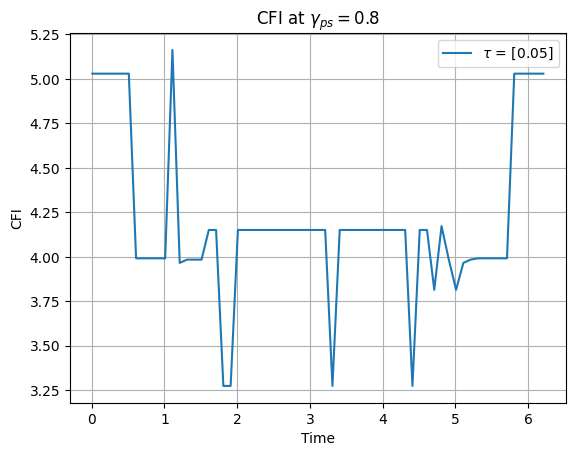

In [13]:
plt.plot(Data[:,0], Data[:,1], label = f'$\\tau$ = {tau_set}')
plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps_set}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()

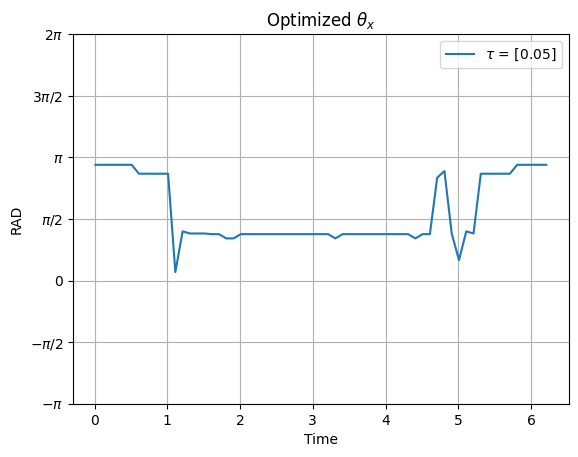

In [14]:
plt.plot(Data[:,0], Data[:,2], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
# plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

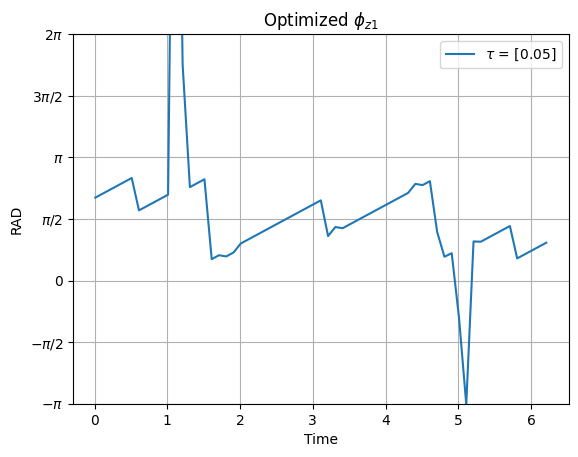

In [15]:
plt.plot(Data[:,0], Data[:,3], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [16]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z1:", f"{Data[idx, 3]:.8f}")

PHI: 0.01 phi_z1: 2.11420845
PHI: 0.11 phi_z1: 2.21420858
PHI: 0.21 phi_z1: 2.31420846
PHI: 0.31 phi_z1: 2.41420847
PHI: 0.41 phi_z1: 2.51420845
PHI: 0.51 phi_z1: 2.61420842
PHI: 0.61 phi_z1: 1.78853465
PHI: 0.71 phi_z1: 1.88853499
PHI: 0.81 phi_z1: 1.98853466
PHI: 0.91 phi_z1: 2.08853486
PHI: 1.01 phi_z1: 2.18853499
PHI: 1.11 phi_z1: 18.72247500
PHI: 1.21 phi_z1: 5.50709385
PHI: 1.31 phi_z1: 2.38204121
PHI: 1.41 phi_z1: 2.48204138
PHI: 1.51 phi_z1: 2.58204122
PHI: 1.61 phi_z1: 0.54470124
PHI: 1.71 phi_z1: 0.64470137
PHI: 1.81 phi_z1: 0.61441444
PHI: 1.91 phi_z1: 0.71441469
PHI: 2.01 phi_z1: 0.94470124
PHI: 2.11 phi_z1: 1.04470144
PHI: 2.21 phi_z1: 1.14470126
PHI: 2.31 phi_z1: 1.24470128
PHI: 2.41 phi_z1: 1.34470128
PHI: 2.51 phi_z1: 1.44470132
PHI: 2.61 phi_z1: 1.54470110
PHI: 2.71 phi_z1: 1.64470127
PHI: 2.81 phi_z1: 1.74470128
PHI: 2.91 phi_z1: 1.84470128
PHI: 3.01 phi_z1: 1.94470133
PHI: 3.11 phi_z1: 2.04470122
PHI: 3.21 phi_z1: 1.13370596
PHI: 3.31 phi_z1: 1.36399279
PHI: 3.41 phi

In [17]:
get_constraints(1.51)

[(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]

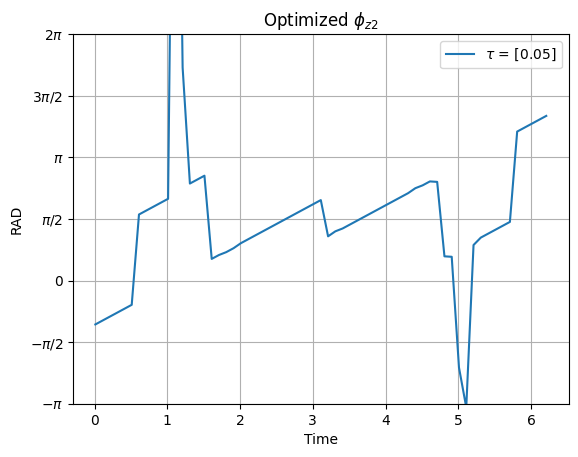

In [18]:
plt.plot(Data[:,0], Data[:,4], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z2}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [19]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z2:", f"{Data[idx, 4]:.8f}")

PHI: 0.01 phi_z2: -1.11966106
PHI: 0.11 phi_z2: -1.01966118
PHI: 0.21 phi_z2: -0.91966102
PHI: 0.31 phi_z2: -0.81966108
PHI: 0.41 phi_z2: -0.71966112
PHI: 0.51 phi_z2: -0.61966115
PHI: 0.61 phi_z2: 1.68393293
PHI: 0.71 phi_z2: 1.78393307
PHI: 0.81 phi_z2: 1.88393340
PHI: 0.91 phi_z2: 1.98393318
PHI: 1.01 phi_z2: 2.08393303
PHI: 1.11 phi_z2: 19.08532494
PHI: 1.21 phi_z2: 5.43109772
PHI: 1.31 phi_z2: 2.47303931
PHI: 1.41 phi_z2: 2.57303909
PHI: 1.51 phi_z2: 2.67303926
PHI: 1.61 phi_z2: 0.55123222
PHI: 1.71 phi_z2: 0.65123210
PHI: 1.81 phi_z2: 0.72396734
PHI: 1.91 phi_z2: 0.82396723
PHI: 2.01 phi_z2: 0.95123210
PHI: 2.11 phi_z2: 1.05123213
PHI: 2.21 phi_z2: 1.15123218
PHI: 2.31 phi_z2: 1.25123217
PHI: 2.41 phi_z2: 1.35123215
PHI: 2.51 phi_z2: 1.45123213
PHI: 2.61 phi_z2: 1.55123250
PHI: 2.71 phi_z2: 1.65123214
PHI: 2.81 phi_z2: 1.75123216
PHI: 2.91 phi_z2: 1.85123217
PHI: 3.01 phi_z2: 1.95123235
PHI: 3.11 phi_z2: 2.05123210
PHI: 3.21 phi_z2: 1.12717553
PHI: 3.31 phi_z2: 1.25444003
PHI: 3.

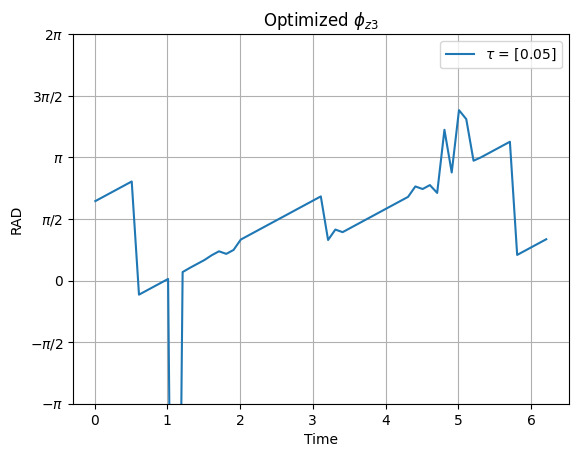

In [20]:
plt.plot(Data[:,0], Data[:,5], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z3}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [21]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z3:", f"{Data[idx, 5]:.8f}")

PHI: 0.01 phi_z3: 2.02556740
PHI: 0.11 phi_z3: 2.12556744
PHI: 0.21 phi_z3: 2.22556737
PHI: 0.31 phi_z3: 2.32556743
PHI: 0.41 phi_z3: 2.42556748
PHI: 0.51 phi_z3: 2.52556760
PHI: 0.61 phi_z3: -0.36033841
PHI: 0.71 phi_z3: -0.26033737
PHI: 0.81 phi_z3: -0.16033812
PHI: 0.91 phi_z3: -0.06033823
PHI: 1.01 phi_z3: 0.03966181
PHI: 1.11 phi_z3: -18.93059408
PHI: 1.21 phi_z3: 0.21581900
PHI: 1.31 phi_z3: 0.32327657
PHI: 1.41 phi_z3: 0.42327658
PHI: 1.51 phi_z3: 0.52327661
PHI: 1.61 phi_z3: 0.64495699
PHI: 1.71 phi_z3: 0.74495701
PHI: 1.81 phi_z3: 0.67934681
PHI: 1.91 phi_z3: 0.77934695
PHI: 2.01 phi_z3: 1.04495671
PHI: 2.11 phi_z3: 1.14495714
PHI: 2.21 phi_z3: 1.24495689
PHI: 2.31 phi_z3: 1.34495701
PHI: 2.41 phi_z3: 1.44495704
PHI: 2.51 phi_z3: 1.54495699
PHI: 2.61 phi_z3: 1.64495686
PHI: 2.71 phi_z3: 1.74495715
PHI: 2.81 phi_z3: 1.84495702
PHI: 2.91 phi_z3: 1.94495701
PHI: 3.01 phi_z3: 2.04495710
PHI: 3.11 phi_z3: 2.14495697
PHI: 3.21 phi_z3: 1.03345004
PHI: 3.31 phi_z3: 1.29906042
PHI: 3.4

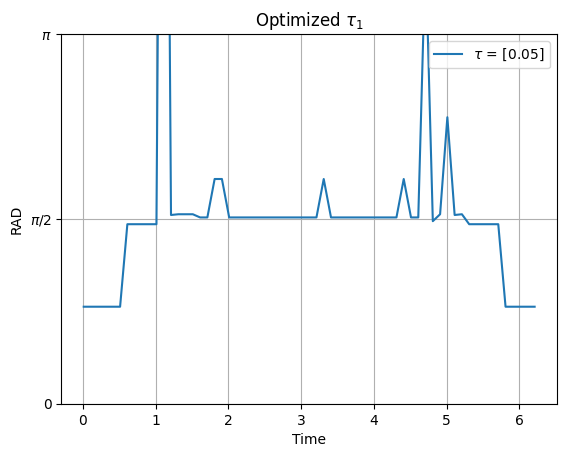

In [22]:
plt.plot(Data[:,0], Data[:,6], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{1}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [23]:
Data[:,6]

array([ 0.82454752,  0.82454754,  0.82454752,  0.82454753,  0.82454753,
        0.82454752,  1.52587056,  1.52587039,  1.5258704 ,  1.52587037,
        1.52587037, 10.43670428,  1.60421727,  1.61050768,  1.61050771,
        1.61050771,  1.58342154,  1.58342155,  1.91014773,  1.91014783,
        1.58342155,  1.58342159,  1.58342153,  1.58342154,  1.58342156,
        1.58342154,  1.58342158,  1.58342156,  1.58342155,  1.58342155,
        1.58342157,  1.58342153,  1.58342149,  1.91014782,  1.58342154,
        1.58342154,  1.58342155,  1.58342154,  1.58342155,  1.58342146,
        1.58342155,  1.58342154,  1.58342154,  1.5834216 ,  1.91014783,
        1.58342155,  1.58342146,  3.84809095,  1.5516475 ,  1.61050771,
        2.43509448,  1.60421727,  1.61050771,  1.52587041,  1.52587043,
        1.52587048,  1.5258704 ,  1.52587045,  0.82454754,  0.82454754,
        0.82454754,  0.82454753,  0.82454752])

In [24]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "tau_1:", f"{Data[idx, 6]:.8f}")

PHI: 0.01 tau_1: 0.82454752
PHI: 0.11 tau_1: 0.82454754
PHI: 0.21 tau_1: 0.82454752
PHI: 0.31 tau_1: 0.82454753
PHI: 0.41 tau_1: 0.82454753
PHI: 0.51 tau_1: 0.82454752
PHI: 0.61 tau_1: 1.52587056
PHI: 0.71 tau_1: 1.52587039
PHI: 0.81 tau_1: 1.52587040
PHI: 0.91 tau_1: 1.52587037
PHI: 1.01 tau_1: 1.52587037
PHI: 1.11 tau_1: 10.43670428
PHI: 1.21 tau_1: 1.60421727
PHI: 1.31 tau_1: 1.61050768
PHI: 1.41 tau_1: 1.61050771
PHI: 1.51 tau_1: 1.61050771
PHI: 1.61 tau_1: 1.58342154
PHI: 1.71 tau_1: 1.58342155
PHI: 1.81 tau_1: 1.91014773
PHI: 1.91 tau_1: 1.91014783
PHI: 2.01 tau_1: 1.58342155
PHI: 2.11 tau_1: 1.58342159
PHI: 2.21 tau_1: 1.58342153
PHI: 2.31 tau_1: 1.58342154
PHI: 2.41 tau_1: 1.58342156
PHI: 2.51 tau_1: 1.58342154
PHI: 2.61 tau_1: 1.58342158
PHI: 2.71 tau_1: 1.58342156
PHI: 2.81 tau_1: 1.58342155
PHI: 2.91 tau_1: 1.58342155
PHI: 3.01 tau_1: 1.58342157
PHI: 3.11 tau_1: 1.58342153
PHI: 3.21 tau_1: 1.58342149
PHI: 3.31 tau_1: 1.91014782
PHI: 3.41 tau_1: 1.58342154
PHI: 3.51 tau_1: 1.

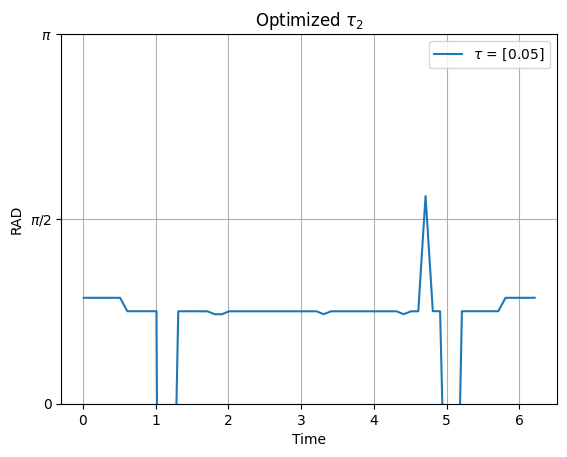

In [25]:
plt.plot(Data[:,0], Data[:,7], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{2}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()